# Import packages and functions

In [1]:
# get custom models and functions
import sys
sys.path.append('../fMRI-reconstruction-NSD/src')
from models import Clipper, BrainNetwork
import utils

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import torch
import os
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
# from tqdm import tqdm
from tqdm.notebook import tqdm
from accelerate import Accelerator
import argparse
import torch.nn as nn

In [3]:
# uses tf32 data type which is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# Multi-GPU config #
accelerator = Accelerator()
print = accelerator.print # only print if local_rank=0

device = accelerator.device
print("device:",device)

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices

print(accelerator.state)
local_rank = accelerator.state.local_process_index
world_size = accelerator.state.num_processes
if num_devices<=1 and world_size<=1:
    distributed=False
else:
    distributed=True
print("distributed =",distributed,"num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)

device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

distributed = False num_devices = 1 local rank = 0 world size = 1


In [4]:
data_dir = '../algonauts_2023_challenge_data'
parent_submission_dir = 'algonauts_2023_challenge_submission'

subj = 1 

# Configurations

In [5]:
# can specify jupyter_args here for argparser to use if running this code interactively
if utils.is_interactive():
    jupyter_args=[]
    jupyter_args.append("--model_name=testing")
    jupyter_args.append("--clip_variant=ViT-L/14")
    jupyter_args.append("--batch_size=128") # smaller to account for more loaded models.
#     jupyter_args.append("--resume_from_ckpt")
    print(jupyter_args)
    
    %load_ext autoreload
    %autoreload 2

['--model_name=testing', '--clip_variant=ViT-L/14', '--batch_size=128']


In [6]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging",
)
parser.add_argument(
    "--batch_size", type=int, default=300,
    help="Our maximum for A100 was 300 for 1dim voxels and 128 for 3dim voxels",
)
parser.add_argument(
    "--clip_variant",type=str,default="ViT-L/14",choices=["RN50", "ViT-L/14", "ViT-B/32", "ViT-H-14", "RN50x64"],
    help='clip / openclip variant',
)
parser.add_argument(
    "--outdir",type=str,default=None,
    help="output directory for logs and checkpoints",
)
# doesn't work in python 3.8
# parser.add_argument(
#     "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
#     help="if not using wandb and want to resume from a ckpt",
# )
parser.add_argument(
    '--resume_from_ckpt',
    action='store_true',
    default=False,
    help='if not using wandb and want to resume from a ckpt.',
)
parser.add_argument(
    "--num_epochs",type=int,default=120,
)
parser.add_argument(
    "--lr_scheduler",type=str,default='cycle',choices=['cycle','fixed'],
)
# doesn't work in python 3.8
# parser.add_argument(
#     "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
# )
parser.add_argument(
    '--no_ckpt_saving',
    action='store_false',
    default=True,
)

parser.add_argument(
    "--ckpt_interval",type=int,default=1,
    help="save ckpt every x epochs",
)
# parser.add_argument(
#     "--save_at_end",action=argparse.BooleanOptionalAction,default=False,
#     help="if False, will save best.ckpt whenever epoch shows best validation score",
# )
parser.add_argument(
    '--save_at_end',
    action='store_true',
    default=False,
    help='if False, will save best.ckpt whenever epoch shows best validation score',
)
# parser.add_argument(
#     "--seed",type=int,default=42,
# )

parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

In [7]:
if outdir is None:
    outdir = os.path.abspath(f'train_logs/{model_name}')
if not os.path.exists(outdir):
    os.makedirs(outdir,exist_ok=True)

# Prep Models and Dataloaders

In [8]:
# Dataset for dataloaders

def _transforms(n_px=256, reshape=False):
    if reshape:
        transform = transforms.Compose([
        transforms.CenterCrop(n_px),
        transforms.Resize(256),
        transforms.ToTensor(), # convert the images to a PyTorch tensor
            ])
    else:
        transform = transforms.Compose([
        transforms.ToTensor(), # convert the images to a PyTorch tensor
            ])
    return transform

class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform=None):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            n_px = min(img.size)
            img = self.transform(n_px, reshape=True)(img).to(device)
        else:
            img = _transforms()(img)
        return img

### COCO Dataloaders

In [9]:
coco_dir = "/scratch/gpfs/KNORMAN/COCO/unlabeled2017_all"

# Create list with all file names, sorted
coco_list = os.listdir(coco_dir)
coco_list.sort()

rand_seed = 5 
np.random.seed(rand_seed)

# Calculate how many COCO images correspond to 90% for training
num_train_coco = int(np.round(len(coco_list) / 100 * 90))
# Shuffle all training stimulus images
idxs_coco = np.arange(len(coco_list))
# np.random.shuffle(idxs)
# Assign 90% of the shuffled images to the training partition,
# and 10% to the test partition
idxs_train_coco, idxs_val_coco = idxs_coco[:num_train_coco], idxs_coco[num_train_coco:]

print('Training COCO images: ' + format(len(idxs_train_coco)))
print('\nValidation COCO images: ' + format(len(idxs_val_coco)))

# Get the paths of all image files
coco_paths = sorted(list(Path(coco_dir).iterdir()))
# The DataLoaders contain the ImageDataset class
train_coco_dl = DataLoader(
    ImageDataset(coco_paths, idxs_train_coco, _transforms), 
    batch_size=batch_size, 
)
val_coco_dl = DataLoader(
    ImageDataset(coco_paths, idxs_val_coco, _transforms), 
    batch_size=batch_size
)

Training COCO images: 111063

Validation COCO images: 12340


### Load Algonauts Images

In [12]:
class argObj:
  def __init__(self, data_dir, parent_submission_dir, subj):
    
    self.subj = format(subj, '02')
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)
    self.parent_submission_dir = parent_submission_dir
    self.subject_submission_dir = os.path.join(self.parent_submission_dir,
        'subj'+self.subj)

    # Create the submission directory if not existing
    if not os.path.isdir(self.subject_submission_dir):
        os.makedirs(self.subject_submission_dir)

args = argObj(data_dir, parent_submission_dir, subj)

train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()
print('Training images: ' + str(len(train_img_list)))
print('Test images: ' + str(len(test_img_list)))

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
# np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))


Training images: 9841
Test images: 159
Training stimulus images: 8857

Validation stimulus images: 984

Test stimulus images: 159



### Get Algonauts fMRI data


In [ ]:

fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

del lh_fmri, rh_fmri

### Algonauts Dataloader

In [ ]:
class AlgDataset(Dataset):
    def __init__(self, imgs_paths, idxs, lh_fmri, rh_fmri, transform=None):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform
        self.lh_fmri = lh_fmri
        self.rh_fmri = rh_fmri

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img)
        return img, torch.from_numpy(self.lh_fmri[idx]), torch.from_numpy(self.rh_fmri[idx])

In [ ]:

# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# Algonauts dataloaders
train_alg_dataloader = DataLoader(
    AlgDataset(train_imgs_paths, idxs_train, lh_fmri_train, rh_fmri_train), 
    batch_size=batch_size, 
)
val_alg_dataloader = DataLoader(
    AlgDataset(train_imgs_paths, idxs_val, lh_fmri_val, rh_fmri_val), 
    batch_size=batch_size
)
# just images
test_alg_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test), 
    batch_size=batch_size
)

# training_clip_dir = "/scratch/gpfs/dw26/algonauts_2023_challenge_data/subj01/training_split/training_clip"
# validation_clip_dir = "/scratch/gpfs/dw26/algonauts_2023_challenge_data/subj01/training_split/validation_clip"
# test_clip_dir = "/scratch/gpfs/dw26/algonauts_2023_challenge_data/subj01/test_split/test_clip"

# if not os.path.isdir(training_clip_dir):
#     os.makedirs(training_clip_dir)
# if not os.path.isdir(validation_clip_dir):
#     os.makedirs(validation_clip_dir)
# if not os.path.isdir(test_clip_dir):
#     os.makedirs(test_clip_dir)

In [13]:
# get clipper
clip_extractor = Clipper("ViT-L/14", device=torch.device(device)) # run in terminal to download

# def img2clipfile(img_paths, dataloader, idxs, clip_dir):
#     running_count=0
#     for img_batch in tqdm(dataloader):
#         clip_batch = clip_extractor.embed_image(img_batch)
#         for clip in clip_batch:
#             clip = clip.cpu().numpy()
#             img_path = img_paths[idxs[running_count]]
#             clip_file_name = str(img_path)[-24:-3]+"npy"
#             np.save(os.path.join(training_clip_dir, clip_file_name), clip)
#             running_count+=1
        
        
# img2clipfile(train_imgs_paths, train_imgs_dataloader, idxs_train, training_clip_dir)
# img2clipfile(train_imgs_paths, val_imgs_dataloader, idxs_val, validation_clip_dir)
# img2clipfile(test_imgs_paths, test_imgs_dataloader, idxs_test, test_clip_dir)


ViT-L/14 cuda



### Clip2Vert and Vert2CLip


In [14]:
class CyclePrototype(nn.Module):
    def __init__(self, brain_dim, clip_dim):
        super().__init__()
        self.brain_dim = dict(out_dim=brain_dim, in_dim=clip_dim)
        self.clip_dim = dict(out_dim=clip_dim, in_dim=brain_dim)
        self.clip2vert = BrainNetwork(**self.brain_dim)
        self.vert2clip = BrainNetwork(**self.clip_dim)
    def forward(self, x, paired=False):
        brain = self.clip2vert(x)
        x = self.vert2clip(brain)
        # whether want both brain activations and clip embedding
        if paired:
            return brain, x
        else:
            return x

In [15]:
brain_dim = 15000
clip_dim = 768
cycle_kwargs = dict(brain_dim=brain_dim, clip_dim=clip_dim)
cycle = CyclePrototype(**cycle_kwargs)

print("params of cycle:")
if local_rank==0:
    utils.count_params(cycle)
    
no_decay = ['bias']
opt_grouped_parameters = [
    {'params': [p for n, p in cycle.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in cycle.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=3e-4) # lr doesnt get used if lr_scheduler='cycle'

if lr_scheduler == 'fixed':
    lr_scheduler = None
elif lr_scheduler == 'cycle':
    global_batch_size = batch_size * num_devices
    total_steps=num_epochs*(num_train//global_batch_size)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):
    ckpt_path = outdir+f'/{tag}.pth'
    print(f'saving {ckpt_path}',flush=True)
    state_dict = cycle.state_dict()
    torch.save({
        'epoch': epoch,
        'model_state_dict': cycle.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'train_losses': losses,
        'val_losses': val_losses,
        'lrs': lrs,
        }, ckpt_path)
        
print("\nDone with model preparations!")


params of cycle:
param counts:
263,527,832 total
263,527,832 trainable

Done with model preparations!




# Huggingface Accelerate


In [16]:
# Algonauts images
cycle, optimizer, train_alg_dataloader, val_alg_dataloader, test_alg_dataloader, lr_scheduler = accelerator.prepare(
    cycle, optimizer, train_alg_dataloader, val_alg_dataloader, test_alg_dataloader, lr_scheduler
)

# COCO images
cycle, optimizer, train_coco_dl, val_coco_dl, lr_scheduler = accelerator.prepare(
    cycle, optimizer, train_coco_dl, val_coco_dl, lr_scheduler
)


# Main


In [17]:
epoch = 0
losses, val_losses, lrs = [], [], []
best_val_loss = 1e9

mse = nn.MSELoss()

# Optionally resume from checkpoint #
if resume_from_ckpt:
    print("\n---resuming from last.pth ckpt---\n")
    checkpoint = torch.load(outdir+'/last.pth')
    epoch = checkpoint['epoch']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    cycle.load_state_dict(checkpoint['model_state_dict'])
    losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0), desc='epochs')
for epoch in progress_bar:
    cycle.train()
    cocoRate = 1 # int number of COCO batches to algonauts batches
    alpha = .5 # fraction of total loss due to brain space loss for algonauts batches
    alg_batches = enumerate(tqdm(train_alg_dataloader, desc='training algonauts'))
    for train_i, coco_image in enumerate(tqdm(train_coco_dataloader, desc='training coco')):
        if train_i%cocoRate==0:
            img_batches = [coco_image, alg_batches.next()]
        else:
            img_batches = [coco_image]
        for j, data in enumerate(img_batches):
            optimizer.zero_grad()
            
        #         repeat_index = train_i % 3
            if j!=0:
                alg_index, image, lh_vert, rh_vert = data

            image = image.float()
            clip_target = clip_extractor.embed_image(image).float()

            if j!=0:
                brain_target = torch.cat(lh_vert, rh_vert)
                brain_pred, clip_pred = cycle(clip_target, paired=True) 
                brain_loss = mse(brain_target, brain_pred)
                clip_loss = mse(clip_target, clip_pred)
                loss = (1-alpha)*clip_loss+alpha*brain_loss
            else:
                brain_pred, clip_pred = cycle(clip_target) 
                loss = mse(clip_target, clip_cycle)
            
            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            accelerator.backward(loss)
            optimizer.step()

            if lr_scheduler is not None:
                lr_scheduler.step()

    cycle.eval()
    if local_rank==0: # i think its possible to remove this if statement though with some revisions
        for val_i, image in enumerate(tqdm(val_imgs_dataloader, desc='validation')): 
            with torch.no_grad():
                # repeat_index = val_i % 3

                image = image.float()

                clip_target = clip_extractor.embed_image(image).float()
                clip_cycle = cycle(clip_target) 
                val_loss =  mse(clip_target, clip_cycle)
                utils.check_loss(val_loss)
                val_losses.append(val_loss.item())

        if (not save_at_end and not no_ckpt_saving) or (save_at_end and epoch == num_epochs - 1):
            # save best model
            val_loss = np.mean(val_losses[-(val_i+1):])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                save_ckpt('best')
            else:
                print(f'not best - val_loss: {val_loss:.3f}, best_val_loss: {best_val_loss:.3f}')
        
        # Save model checkpoint every `ckpt_interval`` epochs or on the last epoch
        if (ckpt_interval is not None and (epoch + 1) % ckpt_interval == 0) or epoch == num_epochs - 1:
            save_ckpt(f'last')

        logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "val/loss": np.mean(val_losses[-(val_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "val/num_steps": len(val_losses)}
        
        progress_bar.set_postfix(**logs)
            
    if distributed:
        dist.barrier()

print("\n===Finished!===\n")


testing starting with epoch 0 / 120


epochs:   0%|                                                                                                 …

training:   0%|          | 0/868 [00:00<?, ?it/s]

validation:   0%|          | 0/97 [00:00<?, ?it/s]

saving /scratch/gpfs/dw26/fMRI-Algonauts-Challenge-2023/train_logs/testing/last.pth


training:   0%|          | 0/868 [00:00<?, ?it/s]

validation:   0%|          | 0/97 [00:00<?, ?it/s]

saving /scratch/gpfs/dw26/fMRI-Algonauts-Challenge-2023/train_logs/testing/last.pth


training:   0%|          | 0/868 [00:00<?, ?it/s]

validation:   0%|          | 0/97 [00:00<?, ?it/s]

saving /scratch/gpfs/dw26/fMRI-Algonauts-Challenge-2023/train_logs/testing/last.pth


training:   0%|          | 0/868 [00:00<?, ?it/s]

KeyboardInterrupt: 

2887
291


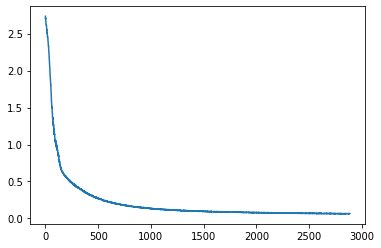

In [18]:
print(len(losses))
print(len(val_losses))
plt.plot(losses)

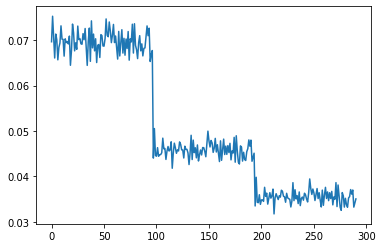

In [19]:
plt.plot(val_losses)